# Data/Label Formatting

In [1]:
import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [4]:
df = pd.read_csv('./data/mean_score.bed', names=['chrom', 'start', 'end', 'SVTYPE', 'score'], sep='\t')

In [5]:
print(len(df))
df.head()

1350


,chrom,start,end,SVTYPE,score
0,3,159257018,159257691,DEL,1.0
1,21,47388020,47389729,DEL,1.0
2,20,52647000,52658030,DEL,1.0
3,11,43909603,43909911,DEL,1.0
4,15,72385965,72388158,DEL,1.0


### Get filenames of the images

In [6]:
def get_filenames(df):
    return f'./data/crop/{df.SVTYPE}_{df.chrom}_{df.start}-{df.end}.crop.png'

In [7]:
df['filename'] = df.apply(get_filenames, axis=1)

In [8]:
df.filename.values[0]

'./data/crop/DEL_3_159257018-159257691.crop.png'

### Get labels from the BED file
For now, let us just do DEL/OTHER as classes.  We will label according to the following criteria:
* if SVTYPE is DEL and score > 0.5 then label as DEL
* else label as OTHER

In [70]:
def get_labels(df):
    if df.SVTYPE == 'DEL' and df.score > 0.5:
        return 1
    else:
        return 0

In [71]:
df['label'] = df.apply(get_labels, axis=1)

In [73]:
len(df[df.label != 1])

206

### Function to load/preprocess image

In [45]:
def load_image(path):
    image = tf.io.read_file(path)
    # most images are 3 channel, but there are some that are 1, and 4 channel
    return tf.image.decode_png(image, channels=3)/255

<dtype: 'float32'>
0.0 1.0


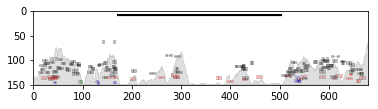

In [57]:
x = load_image(df.sample(n=1).filename.values[0])
print(x.dtype)
print(np.min(x), np.max(x))
plt.imshow(x)

### Build a `tf.data.Dataset`

In [68]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = tf.data.Dataset.from_tensor_slices(df.filename.values). \
                map(load_image, num_parallel_calls=AUTOTUNE)

In [74]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(df.label.values, tf.int64))

In [75]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

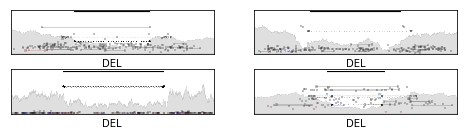

In [84]:
plt.figure(figsize=(8, 2))
label2class = ['OTHER', 'DEL']
for n, (image, label) in enumerate(image_label_ds.take(4)):
    plt.subplot(2, 2, n + 1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'{label2class[label]}')

In [92]:
BATCH_SIZE = 32
ds = image_label_ds.cache() \
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=len(df))) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=AUTOTUNE)
ds


<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int64)>

### Test out dataset

In [89]:
import time
steps_per_epoch=tf.math.ceil(len(df)/BATCH_SIZE).numpy()
default_timeit_steps = 2*steps_per_epoch+1
def timeit(ds, steps=default_timeit_steps):
    overall_start = time.time()
    # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
    # before starting the timer
    it = iter(ds.take(steps+1))
    next(it)
    
    start = time.time()
    for i, (images, labels) in enumerate(it):
        if i%10 == 0:
            print('.', end='')
    print()
    end = time.time()

    duration = end - start
    print(f"{steps} batches: {duration}")
    print(f"{BATCH_SIZE*steps/duration:0.5f} Images/s")
    print(f"Total time: {end-overall_start}s")

In [93]:
timeit(ds)

.........
87.0 batches: 1.6170718669891357
1721.63035 Images/s
Total time: 2.3976869583129883s
